# 1
Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

Для начала определимся с терминами. \
Модуль - это предмет, который может изучаться на протяжернии нескольких семестров. \
Курс - это предмет в рамках одного семестра.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
student_assessment = pd.read_csv('studentAssessment.csv')
student_assessment

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


In [3]:
# Количество студентов
student_assessment.id_student.nunique()

23369

In [4]:
student_assessment.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

In [5]:
student_assessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

Среди оценок есть нулевые значения, неизвестно чем это вызвано, возможно, что это техническая ошибка и оценку не внесли в систему. Удалять эти значения тоже нельзя, иначе получится, что студента не было среди сдававших тест. Пока не понятно помешают ли они расчетам. Необходимо узнать есть ли среди них экзамены. Определим это после объединения с датафреймом с типами тестов.

In [6]:
assessments = pd.read_csv('assessments.csv')

In [7]:
assessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [8]:
assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

In [9]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

Есть пустые значения среди date. Будем трактовать это, как отсутствие дедлайна по сдаче теста.

In [10]:
#объединяем оба датафрейма по идентификационному номеру теста
assessments_all = student_assessment.merge(assessments, how ='inner', on='id_assessment')

In [11]:
assessments_all

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0
...,...,...,...,...,...,...,...,...,...,...
173907,37443,527538,227,0,60.0,GGG,2014J,CMA,229.0,0.0
173908,37443,534672,229,0,100.0,GGG,2014J,CMA,229.0,0.0
173909,37443,546286,215,0,80.0,GGG,2014J,CMA,229.0,0.0
173910,37443,546724,230,0,100.0,GGG,2014J,CMA,229.0,0.0


In [12]:
#Посмотрим какие виды тестов есть
assessments_all.assessment_type.unique()

array(['TMA', 'CMA', 'Exam'], dtype=object)

In [13]:
# Проверим есть ли среди нулевых значаний баллов экзамены
assessments_all[assessments_all['score'].isnull()].query('assessment_type=="Exam"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight


Экзаменов среди нулевых значений нет, расчетам они не помешают.

In [14]:
#Немного исследуем наши данные. Посмотрим сколько в каком модуле экзаменов
assessments.query("assessment_type =='Exam'").code_module.value_counts()

DDD    4
BBB    4
CCC    4
FFF    4
EEE    3
GGG    3
AAA    2
Name: code_module, dtype: int64

In [15]:
# Определим как экзамены по предметам распределены по семестрам 
assessments.query("assessment_type =='Exam'") \
    .groupby(['code_module','code_presentation'], as_index=False) \
    .id_assessment.count()

,code_module,code_presentation,id_assessment
0,AAA,2013J,1
1,AAA,2014J,1
2,BBB,2013B,1
3,BBB,2013J,1
4,BBB,2014B,1
5,BBB,2014J,1
6,CCC,2014B,2
7,CCC,2014J,2
8,DDD,2013B,1
9,DDD,2013J,1


In [16]:
# Рассмотрим подробнее информацию по модулю ССС
assessments.query('code_module=="CCC" and assessment_type =="Exam"')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


In [17]:
# По каким модулям студенты сдавали экзамены
assessments_all.query("assessment_type =='Exam'").code_module.value_counts()

DDD    3044
CCC    1915
Name: code_module, dtype: int64

In [18]:
# Определим какие экзамены по модулю CCC сдавали студенты

assessments_all.query("assessment_type =='Exam' and code_module=='CCC'").id_assessment.unique()

array([24290, 24299], dtype=int64)

В одном семестре по каждому предмету по одному экзамену, за исключением модуля ССС, по которому 2 экзамена в каждом семестре. Но так как экзамены с id_assessment=40087 и 4088 даже ни разу не проводились, будем считать, что для успешной сдачи курса по модулю ССС нужно сдать 1 экзамен.

Логически должно быть, что успешный экзамен не пересдается, проверим эту теорию. Посмотрим есть ли студенты, у которых больше 1 успешной сдачи по каждому экзамену.

In [19]:
assessments_all.query("score>=40 and assessment_type =='Exam'") \
    .groupby(['id_student','id_assessment'], as_index=False) \
    .weight.count() \
    .rename(columns={'weight':'exam_quantity'}) \
    .query('exam_quantity>1')


,id_student,id_assessment,exam_quantity


Таких студентов не нашлось, значит считаем, что за успешный экзамен по курсу модет быть только одна оценка. Теперь можно посчитать количество сданных экзаменов у каждого студента, что и будет являться количеством сданных курсов.

In [20]:
# Найдем сколько экзаменов успешно сдал каждый студент.
students_success_exam = assessments_all.query("score>=40 and assessment_type =='Exam'") \
    .groupby(['id_student'], as_index=False) \
    .weight.count() \
    .rename(columns={'weight':'exam_quantity'})
students_success_exam

,id_student,exam_quantity
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4092,2694886,1
4093,2694933,1
4094,2695608,1
4095,2697181,1


In [21]:
students_success_exam.exam_quantity.value_counts()

1    3802
2     295
Name: exam_quantity, dtype: int64

In [22]:
students_with_1_exam = students_success_exam \
    .query('exam_quantity==1').shape[0]
print('Успешно сдали только один курс {} студента(ов)'.format(students_with_1_exam))

Успешно сдали только один курс 3802 студента(ов)


# 2
Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.
 
 завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [23]:
#Количество всех попыток сдать экзамен
all_exam = assessments_all.query('assessment_type=="Exam"') \
    .groupby(['code_module','id_assessment'], as_index=False) \
    .weight.count() \
    .rename(columns={'weight':'exam_quantity'})
all_exam

,code_module,id_assessment,exam_quantity
0,CCC,24290,747
1,CCC,24299,1168
2,DDD,25340,602
3,DDD,25354,968
4,DDD,25361,524
5,DDD,25368,950


In [24]:
#Количество успешных экзаменов
success_exam=assessments_all.query('assessment_type=="Exam" and score>=40') \
    .groupby(['code_module','id_assessment'], as_index=False) \
    .weight.count() \
    .rename(columns={'weight':'success_exam_quantity'})
success_exam

,code_module,id_assessment,success_exam_quantity
0,CCC,24290,664
1,CCC,24299,1019
2,DDD,25340,504
3,DDD,25354,878
4,DDD,25361,485
5,DDD,25368,842


In [25]:
#Объединим данные в один датафреейм
exam = all_exam.merge(success_exam, on=['id_assessment', 'code_module'])

In [26]:
#Вычислим завершаемость
exam['finishing'] =exam.success_exam_quantity/ exam.exam_quantity

In [27]:
exam

,code_module,id_assessment,exam_quantity,success_exam_quantity,finishing
0,CCC,24290,747,664,0.888889
1,CCC,24299,1168,1019,0.872432
2,DDD,25340,602,504,0.837209
3,DDD,25354,968,878,0.907025
4,DDD,25361,524,485,0.925573
5,DDD,25368,950,842,0.886316


In [28]:
# Определим самую высокую завершаемость
exam.loc[exam['finishing']==exam['finishing'].max()]

,code_module,id_assessment,exam_quantity,success_exam_quantity,finishing
4,DDD,25361,524,485,0.925573


In [29]:
# Определим самую низкую завершаемость
exam.loc[exam['finishing']==exam['finishing'].min()]

,code_module,id_assessment,exam_quantity,success_exam_quantity,finishing
2,DDD,25340,602,504,0.837209


# 3
По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

Под средним сроком сдачи экзамена будем считать среднее количество дней до сдачи экзамена с начала семестра.
Как было выяснено раньше, успешная сдача экзамена (score>=40) у каждого студента по каждому экзамену только 1, поэтому возьмем среднее от всех успешнх экзаменов.

In [30]:
assessments_all.query('assessment_type=="Exam" and score>=40') \
    .groupby(['code_module'], as_index=False) \
    .date_submitted.mean().round()

,code_module,date_submitted
0,CCC,239.0
1,DDD,238.0


Так как длина семестров разная, а предметы изучаются на протяжении нескольких, то посмотрим еще на среднее количество дней в разбивке по семестрам.

In [31]:
assessments_all.query('assessment_type=="Exam" and score>=40') \
    .groupby(['code_module', 'code_presentation'], as_index=False) \
    .date_submitted.mean().round()

,code_module,code_presentation,date_submitted
0,CCC,2014B,232.0
1,CCC,2014J,244.0
2,DDD,2013B,230.0
3,DDD,2013J,240.0
4,DDD,2014B,235.0
5,DDD,2014J,243.0


# 4 
Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3).

In [32]:
# Загрузим данные с информацией о регистрации на курсы
studentRegistration = pd.read_csv('studentRegistration.csv')

In [33]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [34]:
# Посмотрим на типы данных
studentRegistration.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

In [35]:
# Проверим, где есть пустые значения
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

В данном случае нас интересует сам факт попадания студента в список регистрации на курс, поэтому пустые значения в date_registration не будут играть роли.

In [36]:
# Найдем курсы, с наибольшим количеством регистраций
studentRegistration.groupby(['code_module','code_presentation'], as_index=False) \
    .agg({'id_student':'count'}) \
    .sort_values('id_student', ascending=False).head(3)

,code_module,code_presentation,id_student
7,CCC,2014J,2498
18,FFF,2014J,2365
5,BBB,2014J,2292


In [37]:
# Найдем курсы, с самым большим оттоком. 
# Так как pd.count() не считает пустые значения, то достаточно будет посчитать date_unregistration
studentRegistration.groupby(['code_module','code_presentation'], as_index=False) \
    .agg({'date_unregistration':'count'}) \
    .sort_values('date_unregistration', ascending=False).head(3)

,code_module,code_presentation,date_unregistration
7,CCC,2014J,1049
6,CCC,2014B,898
18,FFF,2014J,831


# 5
Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

Как раньше уже определились, завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен. Но на этот раз смотрим в разрезе семестров.

In [38]:
def low_finishing_long_passing(df, semesters):
    
    #Количество всех попыток сдать экзамен
    all_exam_by_semester = df.query('assessment_type=="Exam" \
                                              and code_presentation in @semesters') \
        .groupby('code_presentation', as_index=False) \
        .weight.count() \
        .rename(columns={'weight':'exam_quantity'})

    #Количество успешных экзаменов и средние сроки сдачи курсов
    success_exam_by_semester=df.query('assessment_type=="Exam" \
                                                and score>=40 \
                                                and code_presentation in @semesters') \
        .groupby('code_presentation', as_index=False) \
        .agg({'weight':'count',
             'date_submitted':'mean'}).round()\
        .rename(columns={'weight':'success_exam_quantity',
                        'date_submitted':'avg_day_of_passing_exam'})
     #Объединим данные в один датафреейм
    exam_by_semester = all_exam_by_semester.merge(success_exam_by_semester, on='code_presentation')

    #Вычислим завершаемость
    exam_by_semester['finishing'] =round(exam_by_semester.success_exam_quantity/ exam_by_semester.exam_quantity, 4)

    # Удалим вспомогательные столбцы
    exam_by_semester = exam_by_semester.drop(columns={'exam_quantity','success_exam_quantity'})

    # Определим семестры с самой низкой завершаемостью и с самым долгимсредним сроком сдачи курсов
    result=exam_by_semester.query('finishing==finishing.min() or avg_day_of_passing_exam==avg_day_of_passing_exam.max()')
    
    return result

In [39]:
# Зададим семестры, по которым хотим получить результат
sem=['2013J','2013B','2014J','2014B']

In [40]:
# Вызов функции
low_finishing_long_passing(assessments_all, sem)

,code_presentation,avg_day_of_passing_exam,finishing
0,2013B,230.0,0.8372
3,2014J,244.0,0.8787


# 6
Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики:\
R - среднее время сдачи одного экзамена, \
F - завершаемость курсов,\
M - среднее количество баллов, получаемое за экзамен.\
Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 0.1 до 0.5, monetary от 55 до 72 баллов. 

F-значение \
Для начала определим завершаемость экзаменов в разбивке по студентам.

In [41]:
# Количество все попыток сдать экзамен
student_all_exam = assessments_all.query('assessment_type=="Exam"') \
    .groupby('id_student', as_index=False) \
    .weight.count() \
    .rename(columns={'weight':'exam_quantity'})

#Количество успешных экзаменов
student_success_exam=assessments_all.query('assessment_type=="Exam" \
                                            and score>=40 ') \
    .groupby('id_student', as_index=False) \
    .agg({'weight':'count'}) \
    .rename(columns={'weight':'success_exam_quantity'})
#Объединим данные в один датафреейм
student_exam= student_all_exam.merge(student_success_exam, on='id_student')

#Вычислим завершаемость
student_exam['finishing'] =student_exam.success_exam_quantity/student_exam.exam_quantity

# Удалим вспомогательные столбцы
student_exam = student_exam.drop(columns={'exam_quantity','success_exam_quantity'})

In [42]:
student_exam.head()

,id_student,finishing
0,23698,1.0
1,24213,1.0
2,27116,1.0
3,28046,1.0
4,28787,1.0


In [43]:
# Посмотрим какие значения есть и сколько их
student_exam.finishing.value_counts()

1.0    4069
0.5      28
Name: finishing, dtype: int64

Есть всего 2 значения, поэтому разобьем данные на 2 сегмента: \
1 - от 0 до 0,5 - низкая завершаемость \
2 - от 0,5 до 1 - высокая завершаемость
    

In [44]:
student_exam['F'] = pd.cut(student_exam.finishing, [0, 0.5, 1], labels=[1, 2])

R-значение и М-значение \
Теперь найдем значения среднего количества баллов и среднее время сдачи для каждого студента

In [45]:
score_day = assessments_all.query('assessment_type=="Exam"') \
    .groupby('id_student', as_index=False) \
    .agg({'date_submitted':'mean',
          'score':'mean'  }) \
    .rename(columns={'score':'average_score',
                        'date_submitted':'average_num_of_day'})
score_day

,id_student,average_num_of_day,average_score
0,23698,243.0,80.0
1,24213,236.0,58.0
2,27116,243.0,96.0
3,28046,237.0,40.0
4,28787,243.0,44.0
...,...,...,...
4628,2694886,236.0,69.0
4629,2694933,230.0,73.0
4630,2695608,237.0,73.0
4631,2697181,230.0,80.0


Необходимо определить какие группы выделить для среднего времени сдачи экзаменов. Для начала посмотрим на информацию об окончательной дате сдачи теста для предметов по которым сдавались экзамены (ССС и DDD).

In [46]:
assessments.query('assessment_type=="Exam" and (code_module=="CCC" or code_module=="DDD")')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0
87,DDD,2013B,25340,Exam,240.0,100.0
94,DDD,2013J,25354,Exam,261.0,100.0
101,DDD,2014B,25361,Exam,241.0,100.0
108,DDD,2014J,25368,Exam,NaN,100.0


По большинству экзаменов нет сроков сдачи и данной информации недостаточно. Тогда посмотрим на продолжительность семестров. Для этого считаем данные из courses.

In [47]:
courses= pd.read_csv('courses.csv')
courses.query('code_module=="CCC" or code_module=="DDD"')

,code_module,code_presentation,module_presentation_length
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262
10,DDD,2013B,240
11,DDD,2014B,241


In [48]:
# продолжительность семестров для ССС и DDD
courses.query('code_module=="CCC" or code_module=="DDD"')\
    .module_presentation_length.describe()

count      6.000000
mean     252.333333
std       13.079246
min      240.000000
25%      241.000000
50%      251.000000
75%      261.750000
max      269.000000
Name: module_presentation_length, dtype: float64

Таким образом если среднее время сдачи меньше 240 дней, то все экзамены точно сданы в срок или раньше, а если больше 269 дней, то точно экзамены сдавались после окончания семестра.

Посмотрим на средние значения сдачи по каждому студенту . Определим какие значения принимает эта переменная.

In [49]:
# средние значения сдачи экзамена 
score_day.average_num_of_day.describe()

count    4633.000000
mean      238.462227
std         5.653378
min       229.000000
25%       234.000000
50%       241.000000
75%       243.000000
max       285.000000
Name: average_num_of_day, dtype: float64

Возьмем минимальное значение для нижней границы значения, а максимальное для верхней. Разделим R-значение на 3 группы: \
3 - от 228 до 240 -  время ниже среднего \
2 - от 248 до 269 - среднее время\
1 - от 269 до 286 - время выше среднего\
Расположили группы в порядке убывания намеренно, чтобы студенты, сдающие экзамены раньше оказались в последней.

In [50]:
score_day['R'] = pd.cut(score_day.average_num_of_day, [228, 240, 269, 286], labels=[3, 2, 1])

М - значение\
Среднее количество баллов получаемое за экзамен разобьем по следующим кластерам:\
1 - 0 до 39 баллов - неудовлетворительно \
2 - от 39 до 60 -  удовлетворительно\
3 - от 60 до 80 - хорошо \
4 - от 80 до 100 - отлично

In [51]:
score_day['M'] = pd.cut(score_day.average_score, [0, 39, 60, 80, 100], labels=[1, 2, 3, 4])


In [52]:
score_day

,id_student,average_num_of_day,average_score,R,M
0,23698,243.0,80.0,2,3
1,24213,236.0,58.0,3,2
2,27116,243.0,96.0,2,4
3,28046,237.0,40.0,3,2
4,28787,243.0,44.0,2,2
...,...,...,...,...,...
4628,2694886,236.0,69.0,3,3
4629,2694933,230.0,73.0,3,3
4630,2695608,237.0,73.0,3,3
4631,2697181,230.0,80.0,3,3


In [53]:
# Объединим получившиеся датафреймы в один
rfm = score_day.merge(student_exam, on='id_student')

In [54]:
rfm

,id_student,average_num_of_day,average_score,R,M,finishing,F
0,23698,243.0,80.0,2,3,1.0,2
1,24213,236.0,58.0,3,2,1.0,2
2,27116,243.0,96.0,2,4,1.0,2
3,28046,237.0,40.0,3,2,1.0,2
4,28787,243.0,44.0,2,2,1.0,2
...,...,...,...,...,...,...,...
4092,2694886,236.0,69.0,3,3,1.0,2
4093,2694933,230.0,73.0,3,3,1.0,2
4094,2695608,237.0,73.0,3,3,1.0,2
4095,2697181,230.0,80.0,3,3,1.0,2


In [55]:
#Создадим колонку RFM
rfm['RFM']=rfm.R.astype(str)+rfm.F.astype(str)+rfm.M.astype(str)

In [56]:
rfm

,id_student,average_num_of_day,average_score,R,M,finishing,F,RFM
0,23698,243.0,80.0,2,3,1.0,2,223
1,24213,236.0,58.0,3,2,1.0,2,322
2,27116,243.0,96.0,2,4,1.0,2,224
3,28046,237.0,40.0,3,2,1.0,2,322
4,28787,243.0,44.0,2,2,1.0,2,222
...,...,...,...,...,...,...,...,...
4092,2694886,236.0,69.0,3,3,1.0,2,323
4093,2694933,230.0,73.0,3,3,1.0,2,323
4094,2695608,237.0,73.0,3,3,1.0,2,323
4095,2697181,230.0,80.0,3,3,1.0,2,323


In [57]:
# посмотрим какие RFM-кластеры образовались
rfm.RFM.unique()

array(['223', '322', '224', '222', '323', '324', '311', '312', '211',
       '212', '122'], dtype=object)

Описание, получившихся групп студентов:

'322' - плохо успевающие студенты, сдали все и в срок\
'323' - хорошо успевающие студенты, сдали всё и в срок\
'324' - отличники, сдали все и в срок\
'311' - отстающие студенты, сдавшие не все экзамены, но приходят на экзамен в срок\
'312' - плохо успевающие студенты, сдавшие не все экзамены, но приходят на экзамен в срок\
'211' - отстающие студенты, сдавшие не все экзамены в среднее время\
'212' - плохо успевающие студенты, сдавшие не все экзамены в среднее время\
'222' - плохо успевающие студенты, сдали всё и в среднее время\
'223' - хорошо успевающие студенты, сдали всё и в среднее время\
'224' - отличники, сдали всё и в среднее время\
'122' - плохо успевающие студенты, сдавшие все экзамены, но уже после окончания семестра

В результате можно все группы условно разделить на:

* успешных студентов(success student): 324,323,224
* студентов с большими проблемами в обучении(failure student): 211,311,212,312
* "середнячков"(middle student): 222,223,122,322

In [58]:
# Посчитаем количество студентов в получившихся кластерах
rfm_count = rfm.agg({'RFM':'value_counts'}).reset_index().rename(columns={'RFM':'student_quantity',
                                                                         'index':'RFM'})
rfm_count

,RFM,student_quantity
0,223,751
1,222,731
2,323,723
3,322,673
4,224,661
5,324,528
6,312,18
7,311,5
8,212,3
9,211,2


In [59]:
# Функция для условного деления на группы
def student_group(var_rfm):
    if var_rfm=='324' or var_rfm=='323' or var_rfm=='224':
        var_group="success student"
    elif var_rfm=='211' or var_rfm=='311' or var_rfm=='212' or var_rfm=='312':
        var_group="failure student"
    elif var_rfm=='222' or var_rfm=='223' or var_rfm=='122' or var_rfm=='322':
        var_group="middle student"
    else: var_group='none'
    return var_group

In [60]:
# Разделим студентов по условным группам
rfm_count['group'] = rfm_count.RFM.apply(lambda x: student_group(x))
rfm_count

,RFM,student_quantity,group
0,223,751,middle student
1,222,731,middle student
2,323,723,success student
3,322,673,middle student
4,224,661,success student
5,324,528,success student
6,312,18,failure student
7,311,5,failure student
8,212,3,failure student
9,211,2,failure student


<AxesSubplot:xlabel='RFM', ylabel='student_quantity'>

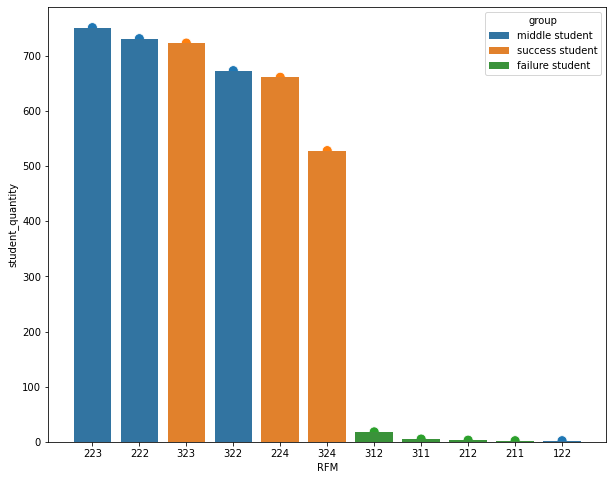

In [64]:
# Визуализируем, получившийся результат
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=rfm_count, x='RFM', y='student_quantity', hue='group', dodge=False)

# Добавим еще точки на график, чтобы видеть какой группе принадлежат очень маленькие значения
sns.scatterplot(data=rfm_count, x='RFM', y='student_quantity', hue='group',s = 100, legend =False)

FM-анализ\
Показывает распределение студентов по завершаемости экзаменов и баллам. Помогает оценить количество студентов с хорошей успеваемостью и студентов, которым грозит отчисление.

<AxesSubplot:xlabel='M', ylabel='F'>

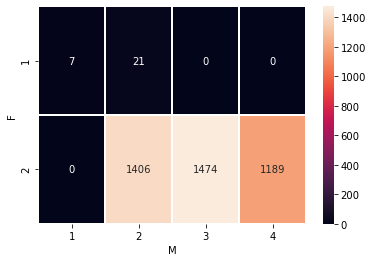

In [62]:
rm=rfm.groupby(['F','M'], as_index=False).id_student.count()\
    .pivot(index='F',columns='M',values='id_student')

f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(rm, annot=True, fmt="d", linewidths=.5, ax=ax)


Какие действия можно предпринять по результатам RFM-анализа?

Для успешных студентов можно разработать систему поощрени. Напимер, скидку на дальнейшее обучение, предложение участвовать в проводимых научных исследованиях, приоритетный выбор мест стажировок и т.д. 

Отстающим студентам предложить дополнительные занятия по прошедшим курсам.

Группе "середнячков" можно напомнить общую информацию: контакты, режим работы деканата, как действовать в случае возникающих проблем, сообщить о существующих дополнительных занятиях и т.д.
